In [1]:
!pip install wordcloud

from datasets import load_from_disk
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/imenbenammar/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/imenbenammar/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
# Defining functions to use

def load_full_dataset(dataset_path):
    """
    Loads the dataset from the specified path, combines the train, validation, and test splits into a single DataFrame, 
    shuffles the data, and returns the full dataset.
    
    Input:
    - dataset_path (str): Path to the dataset.
    Output:
    - full_df (pd.DataFrame): The concatenated and shuffled DataFrame containing the full dataset.
    """
    dataset = load_from_disk(dataset_path)
    # convert the train, validation, and test splits to a pd dataframe
    train_df = dataset['train'].to_pandas()
    test_df = dataset['test'].to_pandas()
    validation_df = dataset['validation'].to_pandas()   
    full_df = pd.concat([train_df, validation_df, test_df], ignore_index=True)
    # shuffle
    full_df = full_df.sample(frac=1, random_state=42).reset_index(drop=True)
    return full_df
    
def display_dataset_info(df):
    """
    Displays dataset info and the first 5 rows.
    
    Input:
    - df (pd.DataFrame): The dataset.
    
    Output:
    - Prints dataset info and first 5 rows.
    """

    print("Dataset info: ")
    df.info()
    print("----------------------------------------------------------------")
    # display the first 5 rows of the dataset
    print("\n First 5 rows of the dataset: ")
    print(df.head())
    print("----------------------------------------------------------------")

def count_nulls(df):
    """
    Counts and returns null values per column.
    
    Input:
    - df (pd.DataFrame): The dataset.
    
    Output:
    - null_counts (pd.Series): Count of nulls per column.
    """
    null_counts = df.isnull().sum()
    return null_counts

def clean_and_tokenize(text, stop_words):
    """
    Cleans and tokenizes text, removing non-alphanumeric characters and stopwords.
    
    Input:
    - text (str): The text to clean and tokenize.
    - stop_words (list): List of stopwords.
    
    Output:
    - filtered_tokens (list): List of cleaned tokens.
    """
    text = re.sub(r'[^A-Za-z0-9\s]', '', text.lower())
    tokens = word_tokenize(text)
    filtered_tokens = [word for word in tokens if word not in stop_words]
    return filtered_tokens

In [4]:
# Functions for plots

def plot_toxicity_subtype_frequency(df, toxicity_columns):
    """
    Plots the frequency of non-zero values for each toxicity subtype column in the dataset.
    
    Input:
    - df (pd.DataFrame): The dataset containing toxicity columns.
    - toxicity_columns (list): List of toxicity columns.
    
    Output:
    - Displays a bar plot of the frequencies of non-zero values for each toxicity subtype.
    """
    # list to store the frequency of non-zero values for each column
    frequencies = []
    # counting non zero values in each toxicity column
    for col in toxicity_columns:
        non_zero_count = (df[col] > 0).sum() 
        frequencies.append(non_zero_count)

    # plot 
    plt.figure(figsize=(7, 4))
    sns.barplot(x=toxicity_columns, y=frequencies, palette="viridis")
    plt.title('Frequency of Each Toxicity Subtype')
    plt.xlabel('Toxicity Subtype')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)
    plt.grid()
    plt.show()


def plot_toxicity_percentage(df, toxicity_labels):
    """
    Plots the percentage of toxic and non-toxic comments based on the specified toxicity labels.
    
    Input:
    - df (pd.DataFrame): The dataset containing toxicity labels.
    - toxicity_labels (list): List of columns representing different toxicity labels.
    
    Output:
    - Displays a pie chart showing the percentage of toxic and non-toxic comments.
    """
    # check if any toxicity label is set for each row
    df['is_toxic'] = df[toxicity_labels].sum(axis=1) > 0  
    # count the number of toxic and non-toxic comments
    toxicity_counts = df['is_toxic'].value_counts()
    
    # prepare data for the pie chart
    labels = ['Non-Toxic', 'Toxic']
    sizes = [toxicity_counts.get(False, 0), toxicity_counts.get(True, 0)]
    explode = (0.1, 0) 
    # plot
    plt.figure(figsize=(7, 4))
    plt.pie(sizes, explode=explode, labels=labels, colors=['#3b528b', '#5ec962'], autopct='%1.1f%%', shadow=True, startangle=90)
    plt.title('Percentage of Toxic and Non-Toxic Comments')
    plt.axis('equal') 
    plt.show()


def plot_wordclouds(df, toxicity_labels, dataset):
    """
    Generates and displays word clouds for toxic and non-toxic comments.
    
    Input:
    - df (pd.DataFrame): The dataset containing the comments and toxicity labels.
    - toxicity_labels (list): List of columns representing toxicity labels.
    - dataset (str): Name of the dataset ('Jigsaw' or 'civil_comments') to select the correct text column.
    
    Output:
    - Displays two word clouds, one for toxic and one for non-toxic comments.
    """
    # create a new column 'is_toxic' and set it to true if one toxicity subtype is present
    df['is_toxic'] = df[toxicity_labels].sum(axis=1) > 0
    # set column name for text
    if (dataset == 'Jigsaw'):
        text_col = 'comment_text'
    elif (dataset == 'civil_comments'):
        text_col = 'text'
    else:
        raise ValueError("Dataset must be either 'Jigsaw' or 'civil_comments'")
    # separate toxic and non-toxic comments
    toxic = ' '.join(df[df['is_toxic']][text_col])
    non_toxic = ' '.join(df[~df['is_toxic']][text_col])
    
    # generate wordclouds
    toxic_wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='Reds', max_words=100).generate(toxic)
    non_toxic_wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='Greens', max_words=100).generate(non_toxic)
    # plot
    plt.figure(figsize=(14, 7))
    # toxic comments word cloud
    plt.subplot(1, 2, 1)
    plt.title('Word Cloud of Toxic Comments', fontsize=16)
    plt.imshow(toxic_wordcloud, interpolation='bilinear')
    plt.axis('off')
    # non-toxic comments word cloud
    plt.subplot(1, 2, 2)
    plt.title('Word Cloud of Non-Toxic Comments', fontsize=16)
    plt.imshow(non_toxic_wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.tight_layout()
    plt.show()


def analyze_comment_len(df, toxicity_labels, dataset):
    """
    Analyzes comment lengths and compares them between toxic and non-toxic comments.
    
    Input:
    - df (pd.DataFrame): Dataset containing comments and toxicity labels.
    - toxicity_labels (list): List of columns indicating toxicity subtypes.
    - dataset (str): Dataset name ('Jigsaw' or 'civil_comments') to select the correct comment column.
    
    Output:
    - Prints basic statistics and displays plots for comment length distribution, comparison between toxic and non-toxic comments, 
    and average comment length by toxicity.
    """
    # set column name for text
    if (dataset == 'Jigsaw'):
        text_col = 'comment_text'
    elif (dataset == 'civil_comments'):
        text_col = 'text'
    else:
        raise ValueError("Dataset must be either 'Jigsaw' or 'civil_comments'")
        
    # create new column and calculate comment lengths
    df['comment_length'] = df[text_col].apply(len)
    
    # display basic statistics of comment lengths
    print("Basic Statistics for Comment Lengths:")
    print(df['comment_length'].describe())
    print("\n")
    
    # plot for distribution of comment lengths
    plt.figure(figsize=(7,4))
    sns.histplot(df['comment_length'], bins=20, kde=True, color='#21918c')
    plt.title('Distribution of Comment Lengths')
    plt.xlabel('Comment Length')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()
    
    # plot to compare comment lengths between Toxic and Non-Toxic comments
    df['is_toxic'] = df[toxicity_labels].sum(axis=1) > 0
    plt.figure(figsize=(7, 4))
    sns.boxplot(data=df, x='is_toxic', y='comment_length', palette='viridis')
    plt.xticks([0, 1], ['Non-Toxic', 'Toxic'])
    plt.title('Comment Length Comparison: Toxic vs. Non-Toxic')
    plt.xlabel('Comment Type')
    plt.ylabel('Comment Length')
    plt.grid(True)
    plt.show()
  
    # plot to visualize the average comment length by toxicity subtype
    plt.figure(figsize=(7, 4))
    toxicity_avg_length = df.groupby('is_toxic')['comment_length'].mean().reset_index()
    sns.barplot(data=toxicity_avg_length, x='is_toxic', y='comment_length', palette='viridis')
    plt.xticks([0, 1], ['Non-Toxic', 'Toxic'])
    plt.title('Average Comment Length: Toxic vs. Non-Toxic')
    plt.xlabel('Comment Type')
    plt.ylabel('Average Comment Length')
    plt.grid(True)
    plt.show()


def plot_common_words_by_subtype(df, toxicity_labels, dataset, threshold=0.8, top_n=10):
    """
    Plots the most common words (top N) in toxic comments for each toxicity label above a specified threshold.
    
    Input:
    - df (pd.DataFrame): Dataset containing comments and toxicity labels.
    - toxicity_labels (list): List of toxicity labels to analyze (e.g., 'severe_toxicity').
    - dataset (str): Name of the dataset ('Jigsaw' or 'civil_comments') to select the correct text column.
    - threshold (float, optional): Minimum toxicity level to consider a comment as toxic (default is 0.8).
    - top_n (int, optional): Number of most common words to display (default is 10).
    
    Output:
    - Displays bar plots for the most common words in toxic comments for each label.
    """

    # set column name for text
    if dataset == 'Jigsaw':
        text_col = 'comment_text'
    elif dataset == 'civil_comments':
        text_col = 'text'
    else:
        raise ValueError("Dataset must be either 'Jigsaw' or 'civil_comments'")
    # define stop words
    stop_words = set(stopwords.words('english'))
    
    # loop through each toxicity label
    for label in toxicity_labels:
        # filter rows where the toxicity value for the label is higher than the threshold
        is_toxic = df[label] > threshold
        toxic_comments = df[is_toxic][text_col]
        
        # tokenize and clean all comments
        all_tokens = []
        for comment in toxic_comments:
            all_tokens.extend(clean_and_tokenize(comment, stop_words))
        
        # frequency of each word
        word_counts = Counter(all_tokens)
        # select top_n most common words
        common_words = word_counts.most_common(top_n)
        # plot 
        if common_words:
            words, counts = zip(*common_words)
            plt.figure(figsize=(8, 6))
            sns.barplot(x=list(counts), y=list(words), palette='viridis')
            plt.title(f'Most Common Words for {label.capitalize()} (Threshold > {threshold})')
            plt.xlabel('Frequency')
            plt.ylabel('Words')
            plt.grid(True)
            plt.show()
        else:
            print(f"No words found for {label.capitalize()} with threshold > {threshold}.")


def plot_toxicity_vs_comment_length(df, label, dataset):
    """
    Plots a scatter plot comparing comment length with a specified toxicity label.
    
    Input:
    - df (pd.DataFrame): Dataset containing comments and the toxicity labels.
    - label (str): The toxicity label to compare against (e.g., 'severe_toxicity').
    - dataset (str): Name of the dataset ('Jigsaw' or 'civil_comments') to select the correct text column.
    
    Output:
    - Displays a scatter plot of comment length vs the specified toxicity label.
    """

    # set column name for text
    if dataset == 'Jigsaw':
        text_col = 'comment_text'
    elif dataset == 'civil_comments':
        text_col = 'text'
    else:
        raise ValueError("Dataset must be either 'Jigsaw' or 'civil_comments'")
    
    # calculate comment length if not already done
    if 'comment_length' not in df.columns:
        df['comment_length'] = df[text_col].apply(len)
    # plot
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=df['comment_length'], y=df[label], alpha=0.3, color='#21918c')
    plt.title(f'Scatter Plot: Comment Length vs. {label.capitalize()}')
    plt.xlabel('Comment Length')
    plt.ylabel(f'{label.capitalize()} Level')
    plt.grid(True)
    plt.show()



In [5]:
# Dataset 1: google/jigsaw_toxicity_pred

train_df = pd.read_csv('../data/jigsaw_toxicity_pred/train.csv')
initial_test_df = pd.read_csv('../data/jigsaw_toxicity_pred/test.csv')
test_labels_df = pd.read_csv('../data/jigsaw_toxicity_pred/test_labels.csv')
toxicity_labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
# filter out rows with toxicity labels = -1
valid_labels_df = test_labels_df[~test_labels_df[toxicity_labels].eq(-1).any(axis=1)]
# merge test data with the filtered valid labels only
test_df = pd.merge(initial_test_df, valid_labels_df, on="id", how="inner")
# combine both train and test sets
df1 = pd.concat([train_df, test_df], ignore_index=True)

display_dataset_info(df1)

Dataset info: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 223549 entries, 0 to 223548
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             223549 non-null  object
 1   comment_text   223549 non-null  object
 2   toxic          223549 non-null  int64 
 3   severe_toxic   223549 non-null  int64 
 4   obscene        223549 non-null  int64 
 5   threat         223549 non-null  int64 
 6   insult         223549 non-null  int64 
 7   identity_hate  223549 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 13.6+ MB
----------------------------------------------------------------

 First 5 rows of the dataset: 
                 id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\r\nWhy the edits made under my use...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not

In [6]:
count_nulls(df1)

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

/var/folders/1m/1wt5d5154bg4twk9y67kbx3w0000gn/T/ipykernel_98968/3483319060.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=toxicity_columns, y=frequencies, palette="viridis")


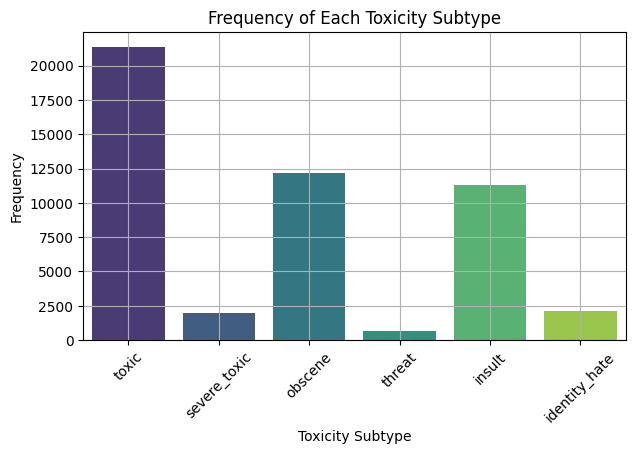

In [7]:
plot_toxicity_subtype_frequency(df1, toxicity_labels)

/var/folders/1m/1wt5d5154bg4twk9y67kbx3w0000gn/T/ipykernel_98968/3483319060.py:209: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette='viridis')


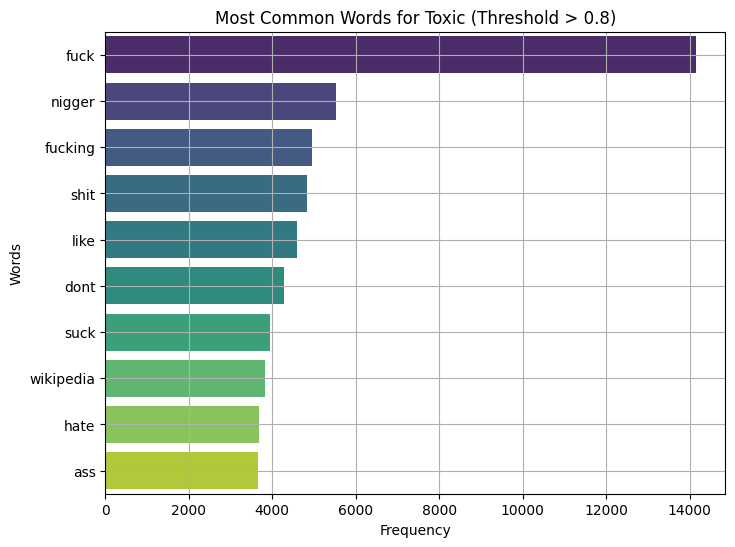

/var/folders/1m/1wt5d5154bg4twk9y67kbx3w0000gn/T/ipykernel_98968/3483319060.py:209: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette='viridis')


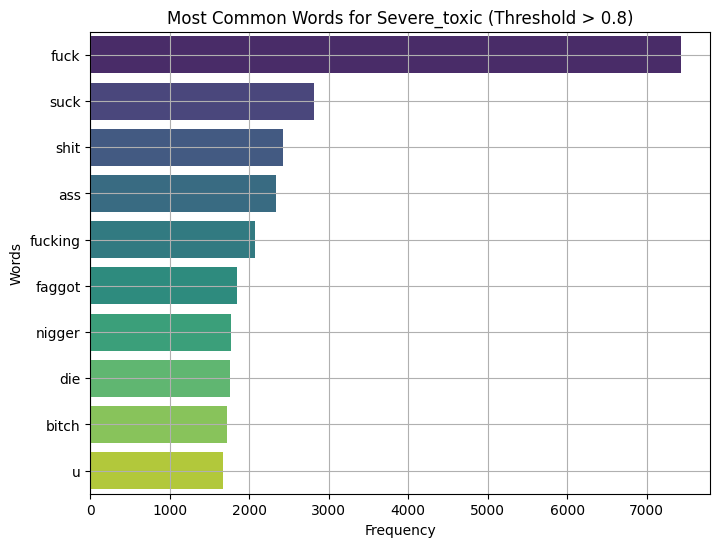

/var/folders/1m/1wt5d5154bg4twk9y67kbx3w0000gn/T/ipykernel_98968/3483319060.py:209: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette='viridis')


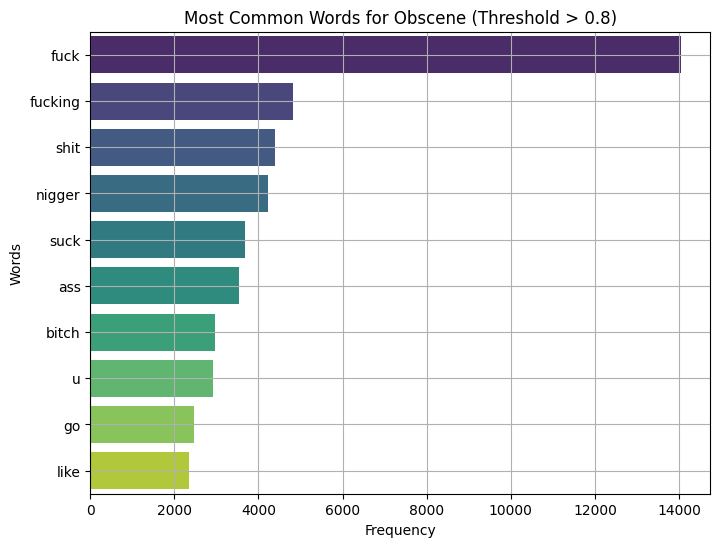

/var/folders/1m/1wt5d5154bg4twk9y67kbx3w0000gn/T/ipykernel_98968/3483319060.py:209: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette='viridis')


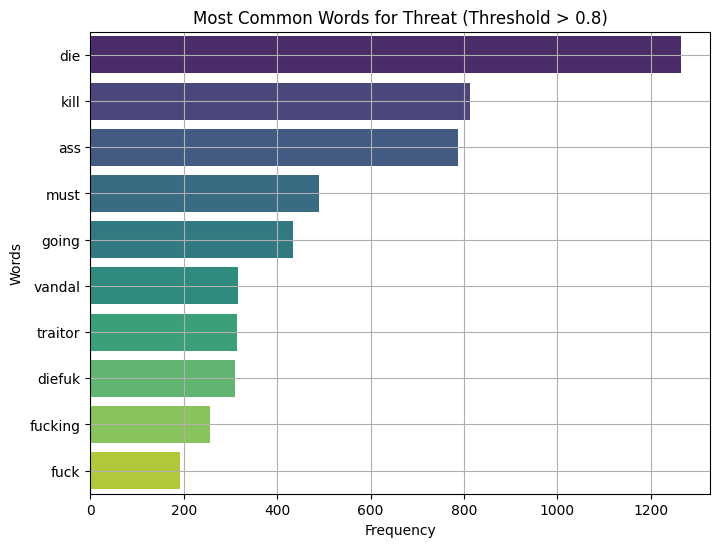

/var/folders/1m/1wt5d5154bg4twk9y67kbx3w0000gn/T/ipykernel_98968/3483319060.py:209: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette='viridis')


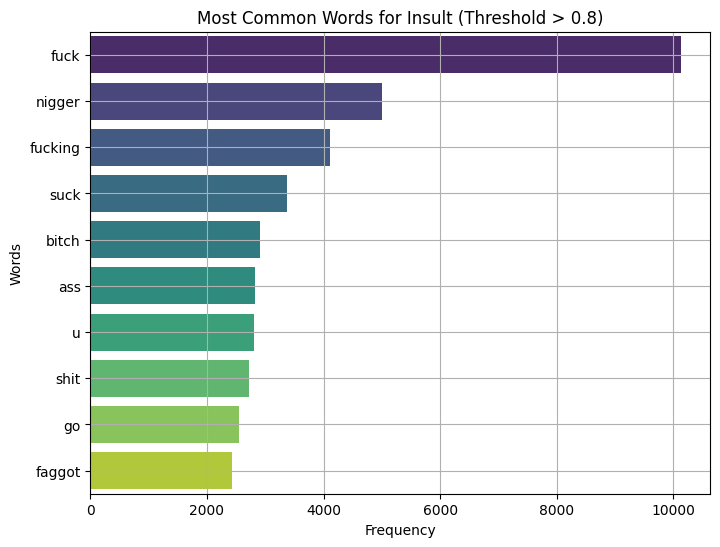

/var/folders/1m/1wt5d5154bg4twk9y67kbx3w0000gn/T/ipykernel_98968/3483319060.py:209: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette='viridis')


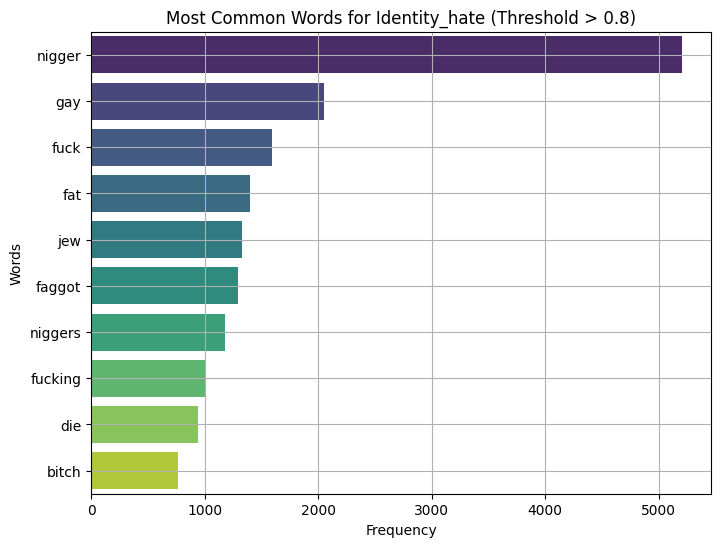

In [8]:
plot_common_words_by_subtype(df1, toxicity_labels, 'Jigsaw')

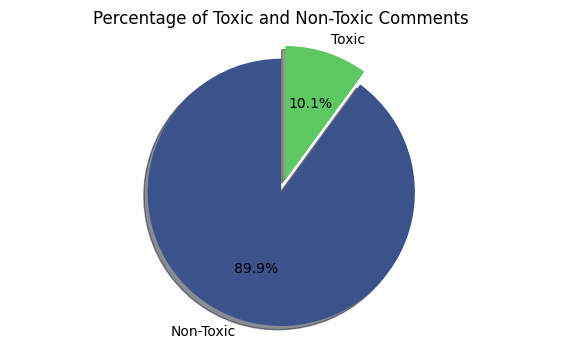

In [9]:
plot_toxicity_percentage(df1,toxicity_labels)

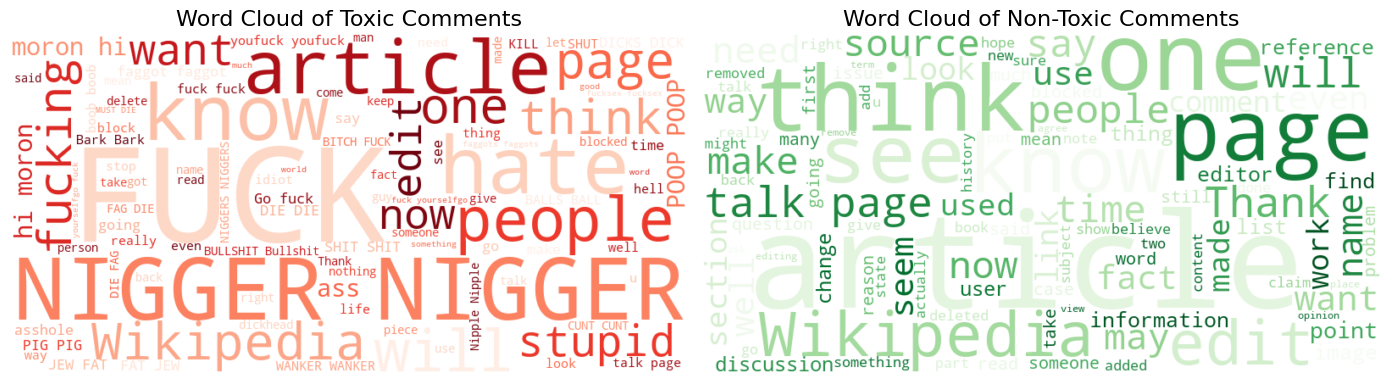

In [10]:
plot_wordclouds(df1, toxicity_labels, 'Jigsaw')

Basic Statistics for Comment Lengths:
count    223549.000000
mean        393.575113
std         596.697051
min           1.000000
25%          94.000000
50%         204.000000
75%         433.000000
max        5000.000000
Name: comment_length, dtype: float64




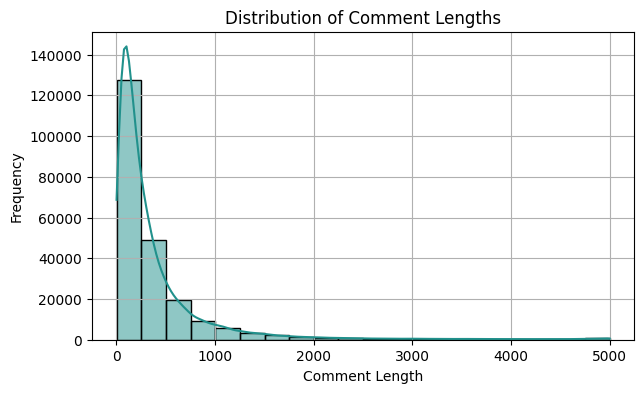

/var/folders/1m/1wt5d5154bg4twk9y67kbx3w0000gn/T/ipykernel_98968/3483319060.py:145: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='is_toxic', y='comment_length', palette='viridis')


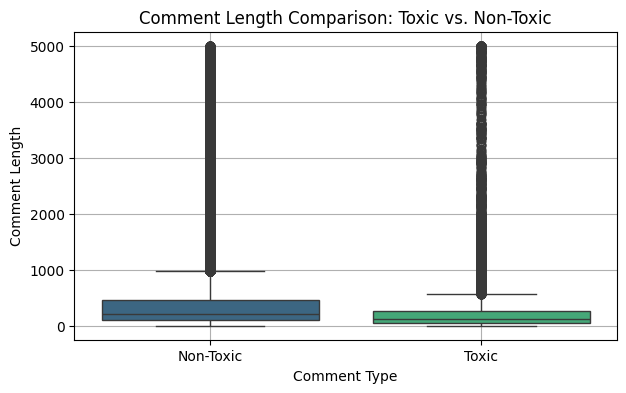

/var/folders/1m/1wt5d5154bg4twk9y67kbx3w0000gn/T/ipykernel_98968/3483319060.py:156: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=toxicity_avg_length, x='is_toxic', y='comment_length', palette='viridis')


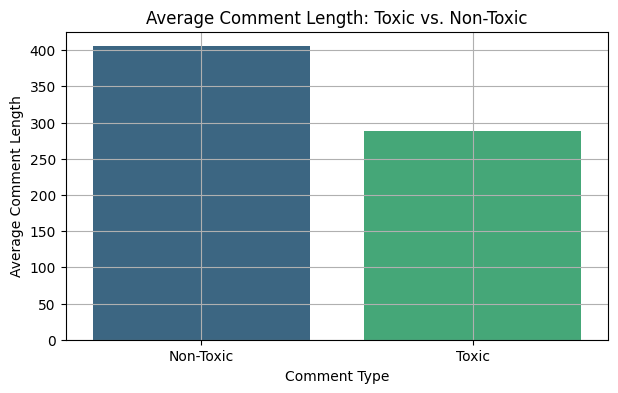

In [11]:
analyze_comment_len(df1, toxicity_labels, 'Jigsaw')

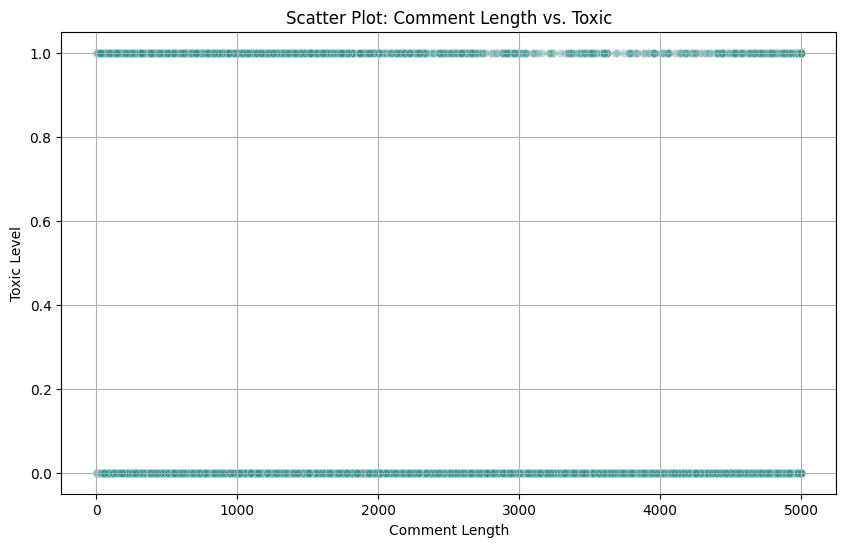

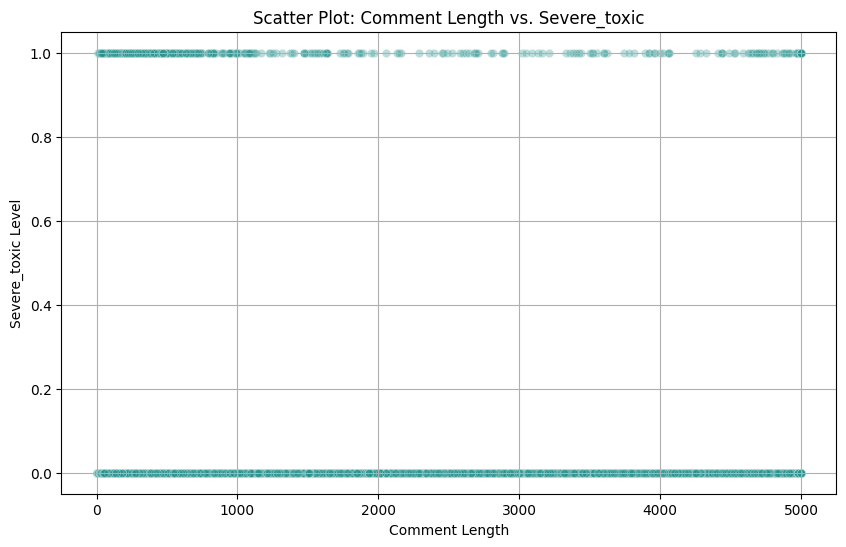

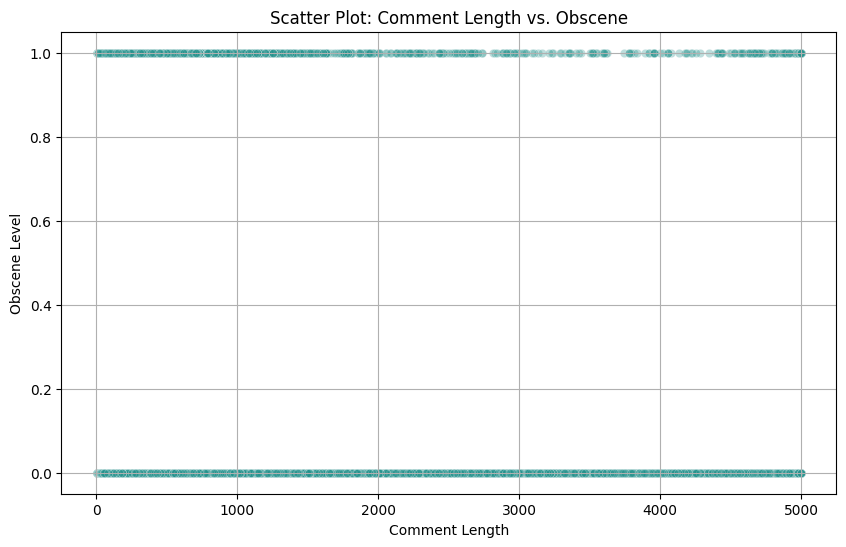

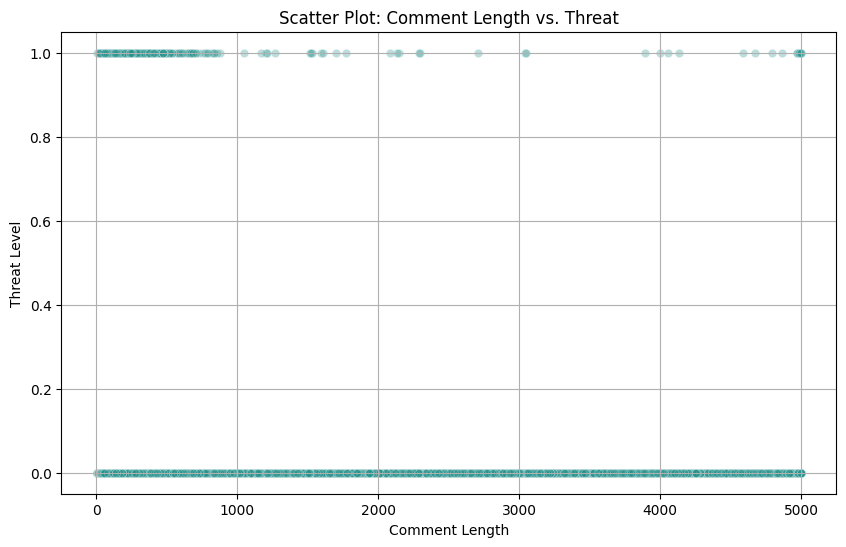

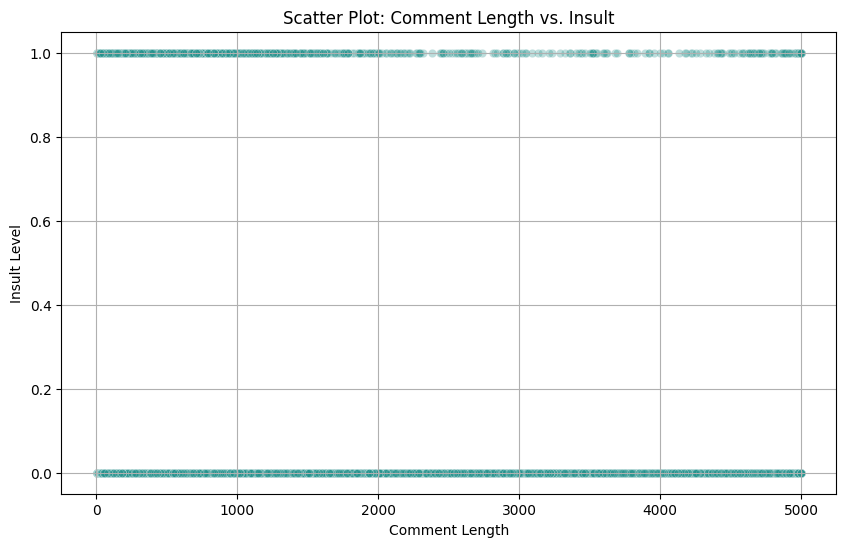

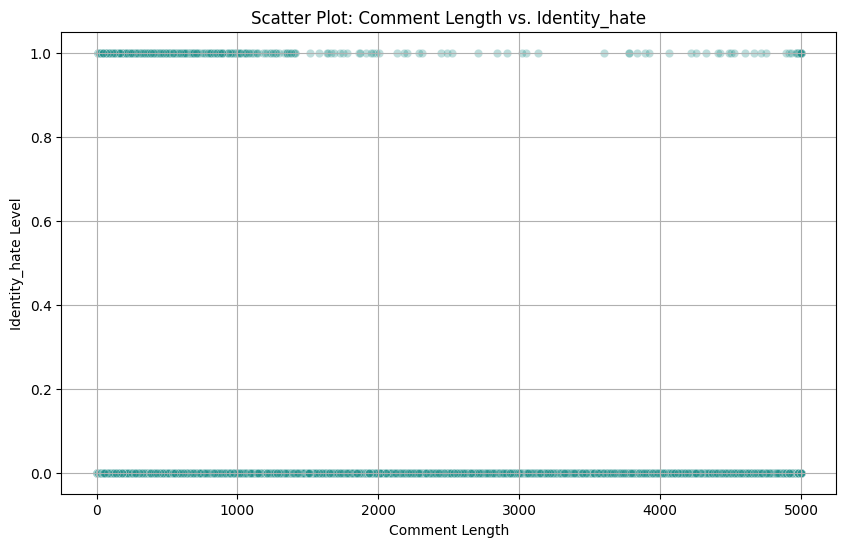

In [12]:
# Note: this is not too useful for this dataset as the toxicity values are either 1 or 0
for label in toxicity_labels:
    plot_toxicity_vs_comment_length(df1, label=label, dataset='Jigsaw')

In [13]:
# Dataset 2: google/civil_comments

df2 = load_full_dataset("../data/finetuning_datasets/civil_comments")
toxicity_labels = ['toxicity', 'severe_toxicity', 'obscene', 'threat', 'insult', 'identity_attack', 'sexual_explicit']

display_dataset_info(df2)

Dataset info: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1999514 entries, 0 to 1999513
Data columns (total 8 columns):
 #   Column           Dtype  
---  ------           -----  
 0   text             object 
 1   toxicity         float32
 2   severe_toxicity  float32
 3   obscene          float32
 4   threat           float32
 5   insult           float32
 6   identity_attack  float32
 7   sexual_explicit  float32
dtypes: float32(7), object(1)
memory usage: 68.6+ MB
----------------------------------------------------------------

 First 5 rows of the dataset: 
                                                text  toxicity  \
0  The last time I heard that a minority was prev...  0.000000   
1  The reason it's all Obama's fault is because h...  0.166667   
2  It's worth fearing decisions based off archaic...  0.000000   
3                                    Ineligible why?  0.000000   
4                              Do your own research.  0.000000   

   severe_toxicity  obscen

In [14]:
count_nulls(df2)

text               0
toxicity           0
severe_toxicity    0
obscene            0
threat             0
insult             0
identity_attack    0
sexual_explicit    0
dtype: int64

/var/folders/1m/1wt5d5154bg4twk9y67kbx3w0000gn/T/ipykernel_98968/3483319060.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=toxicity_columns, y=frequencies, palette="viridis")


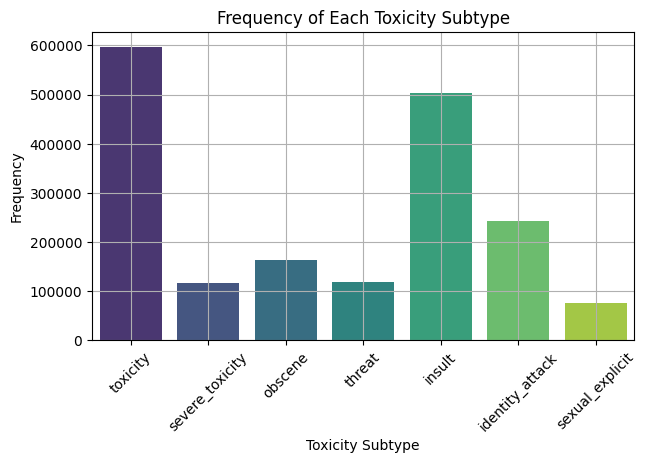

In [15]:
plot_toxicity_subtype_frequency(df2, toxicity_labels)

/var/folders/1m/1wt5d5154bg4twk9y67kbx3w0000gn/T/ipykernel_98968/3483319060.py:209: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette='viridis')


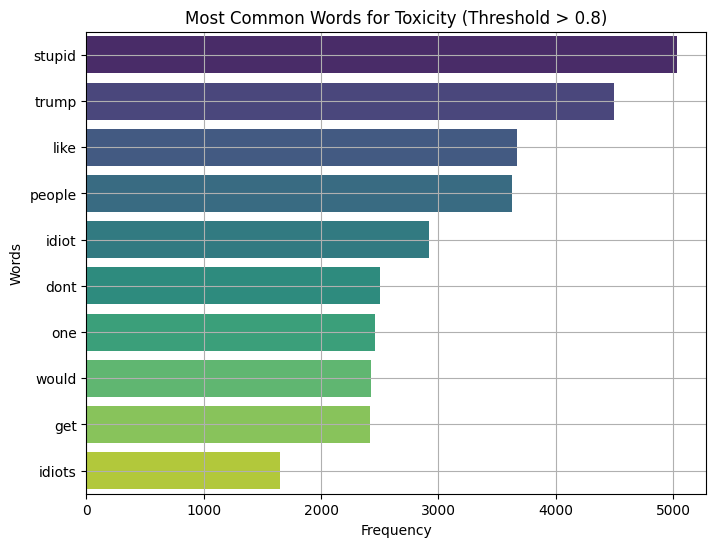

/var/folders/1m/1wt5d5154bg4twk9y67kbx3w0000gn/T/ipykernel_98968/3483319060.py:209: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette='viridis')


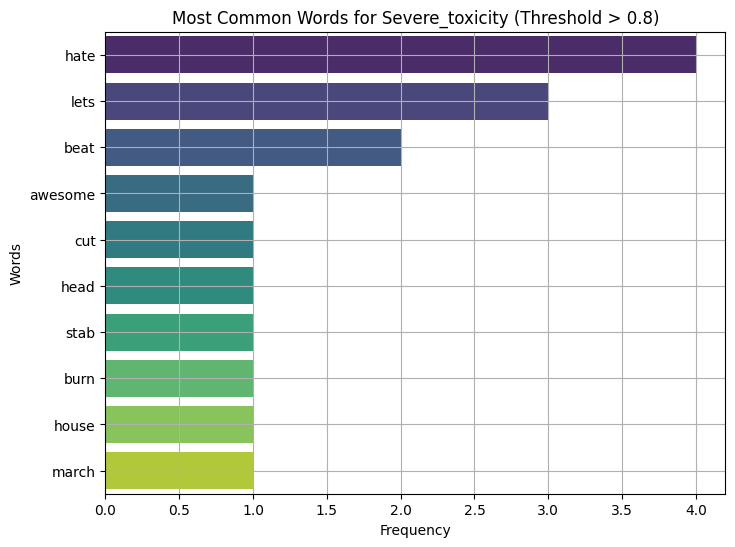

/var/folders/1m/1wt5d5154bg4twk9y67kbx3w0000gn/T/ipykernel_98968/3483319060.py:209: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette='viridis')


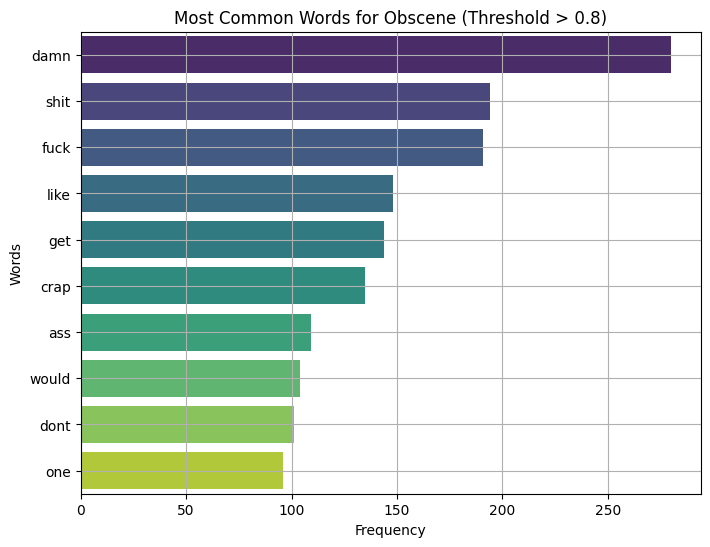

/var/folders/1m/1wt5d5154bg4twk9y67kbx3w0000gn/T/ipykernel_98968/3483319060.py:209: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette='viridis')


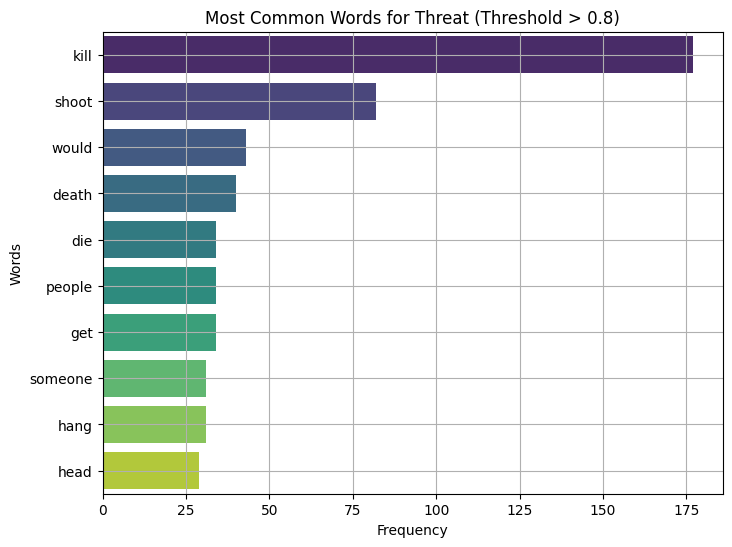

/var/folders/1m/1wt5d5154bg4twk9y67kbx3w0000gn/T/ipykernel_98968/3483319060.py:209: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette='viridis')


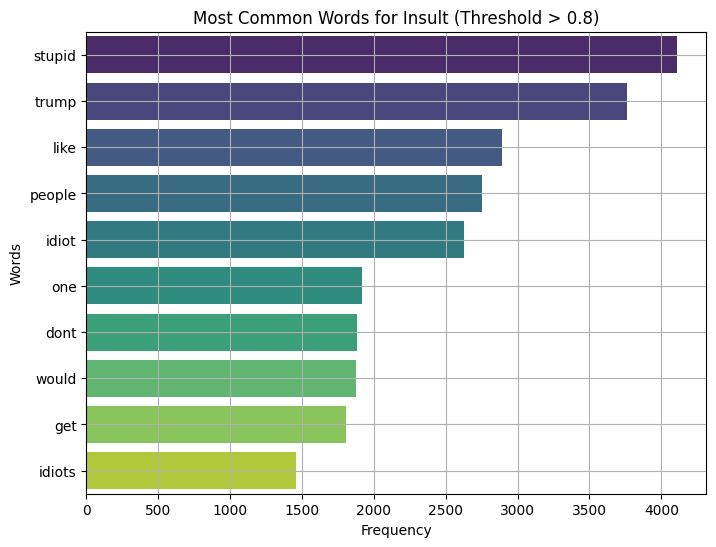

/var/folders/1m/1wt5d5154bg4twk9y67kbx3w0000gn/T/ipykernel_98968/3483319060.py:209: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette='viridis')


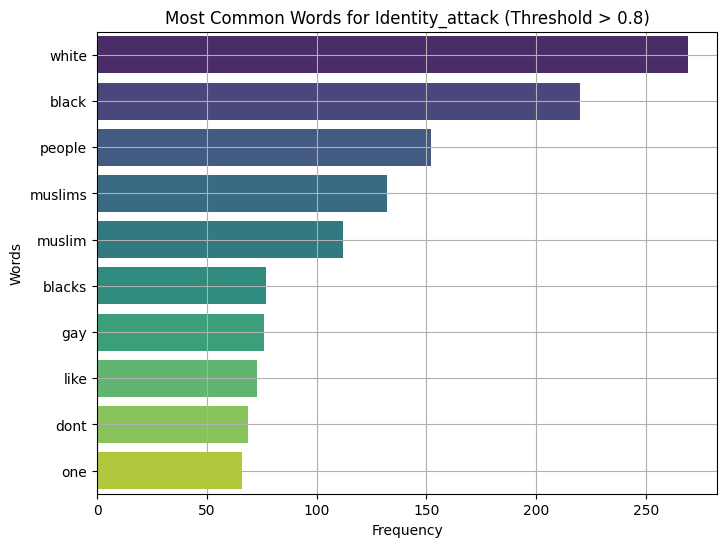

/var/folders/1m/1wt5d5154bg4twk9y67kbx3w0000gn/T/ipykernel_98968/3483319060.py:209: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette='viridis')


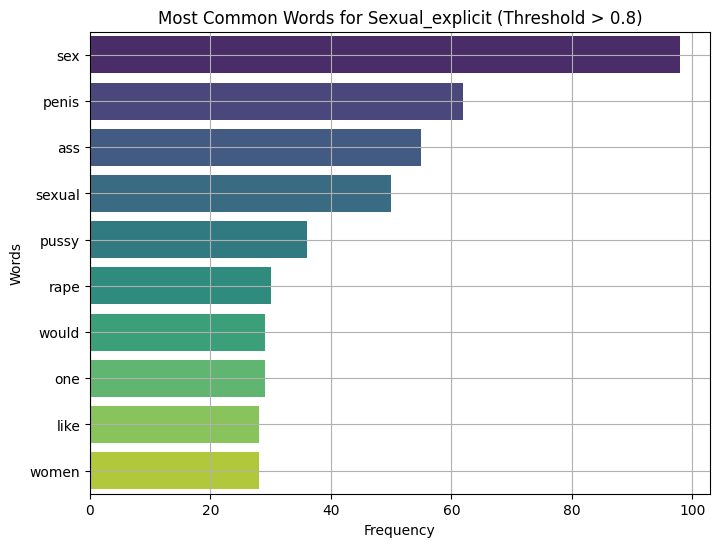

In [16]:
plot_common_words_by_subtype(df2, toxicity_labels, 'civil_comments')

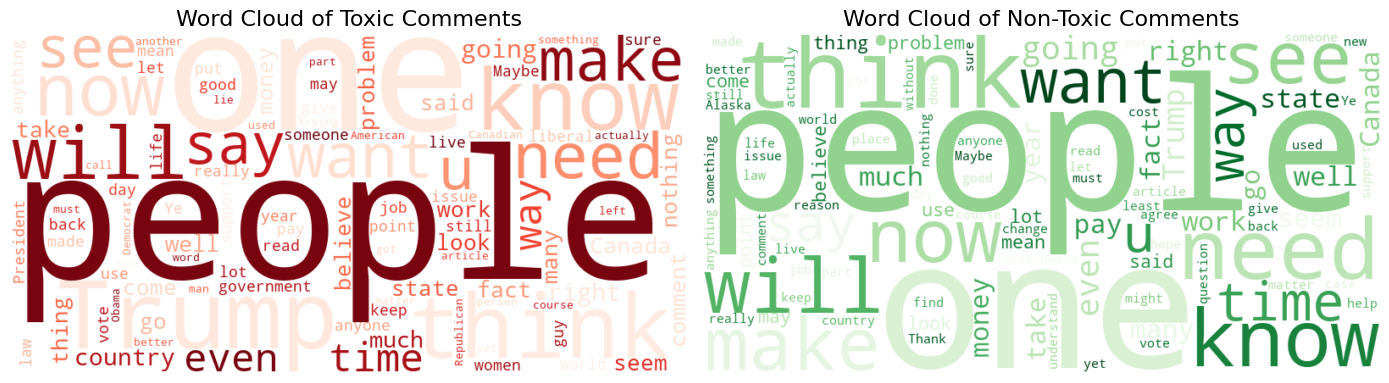

In [17]:
plot_wordclouds(df2, toxicity_labels, 'civil_comments')

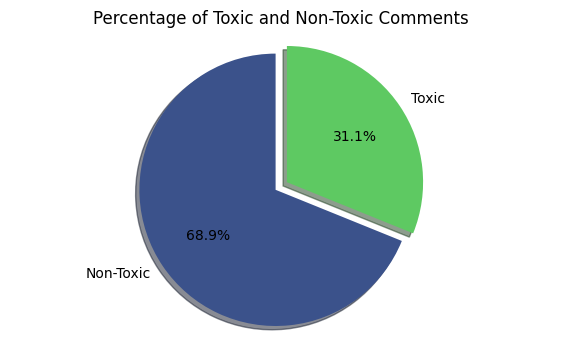

In [18]:
plot_toxicity_percentage(df2, toxicity_labels)

Basic Statistics for Comment Lengths:
count    1.999514e+06
mean     2.972535e+02
std      2.691821e+02
min      1.000000e+00
25%      9.400000e+01
50%      2.020000e+02
75%      4.140000e+02
max      1.971000e+03
Name: comment_length, dtype: float64




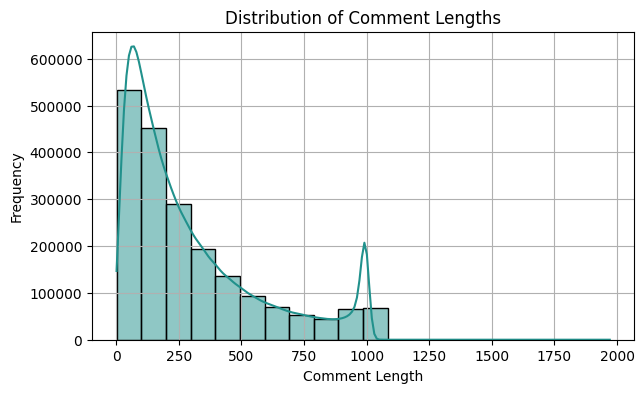

/var/folders/1m/1wt5d5154bg4twk9y67kbx3w0000gn/T/ipykernel_98968/3483319060.py:145: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='is_toxic', y='comment_length', palette='viridis')


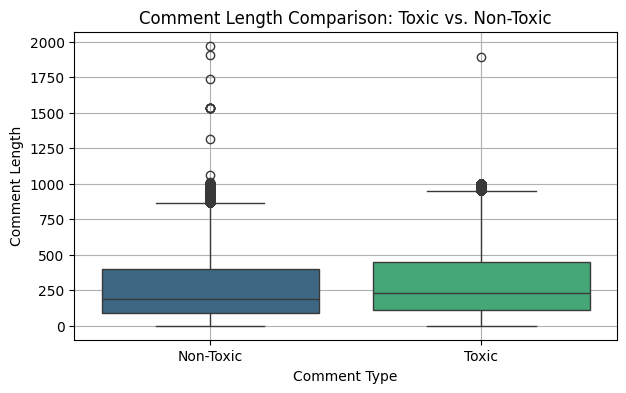

/var/folders/1m/1wt5d5154bg4twk9y67kbx3w0000gn/T/ipykernel_98968/3483319060.py:156: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=toxicity_avg_length, x='is_toxic', y='comment_length', palette='viridis')


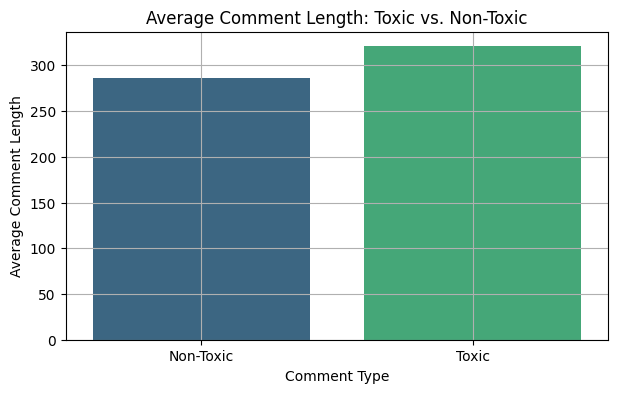

In [19]:
analyze_comment_len(df2, toxicity_labels, 'civil_comments')

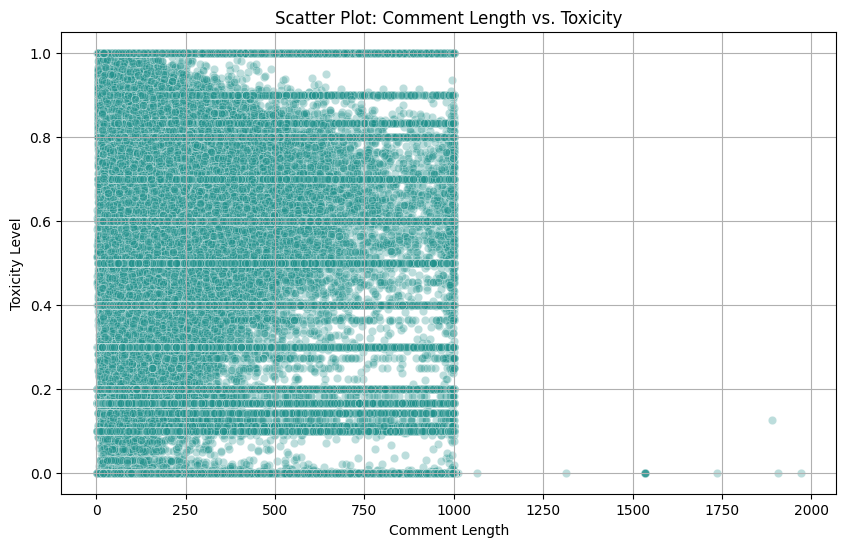

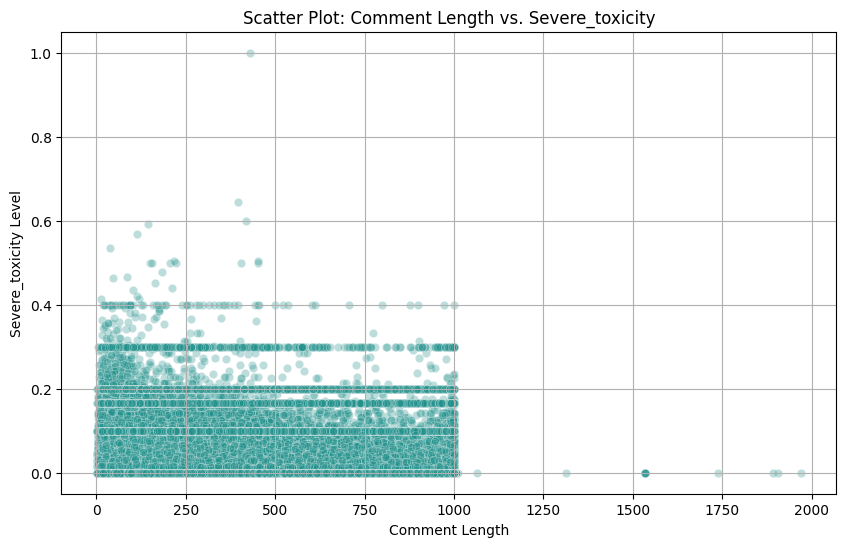

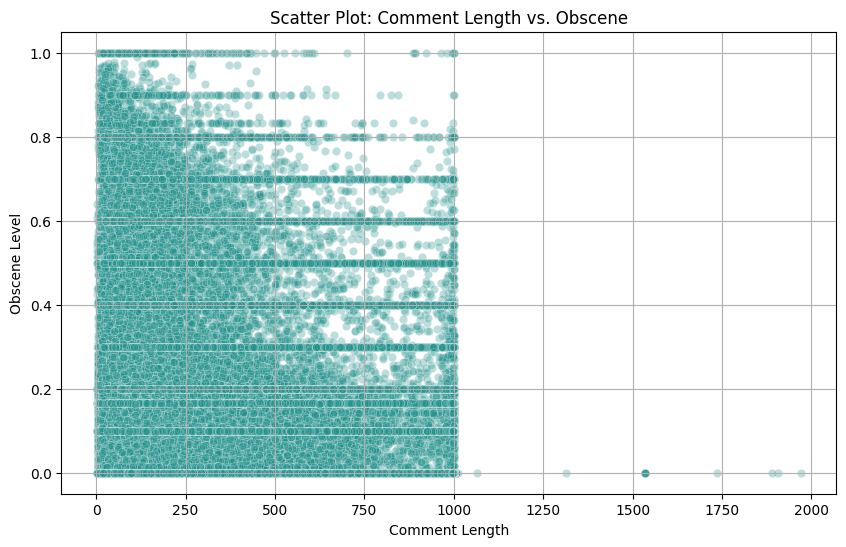

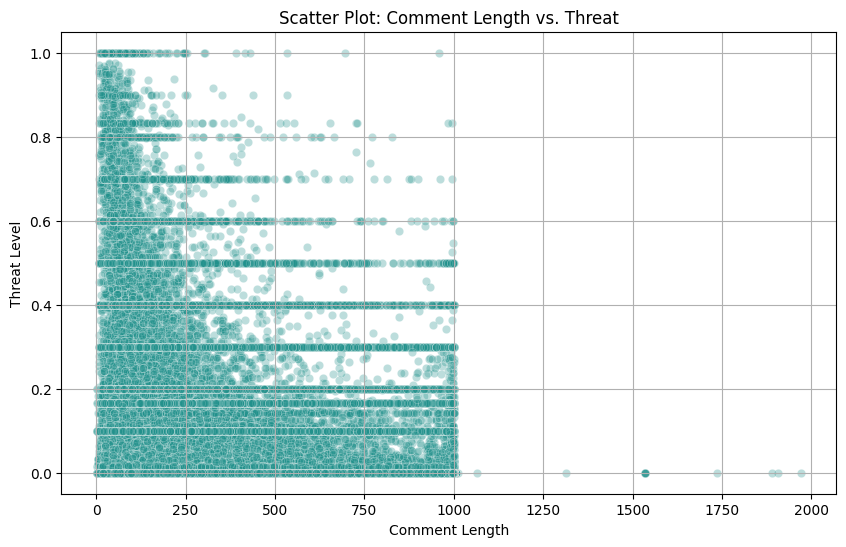

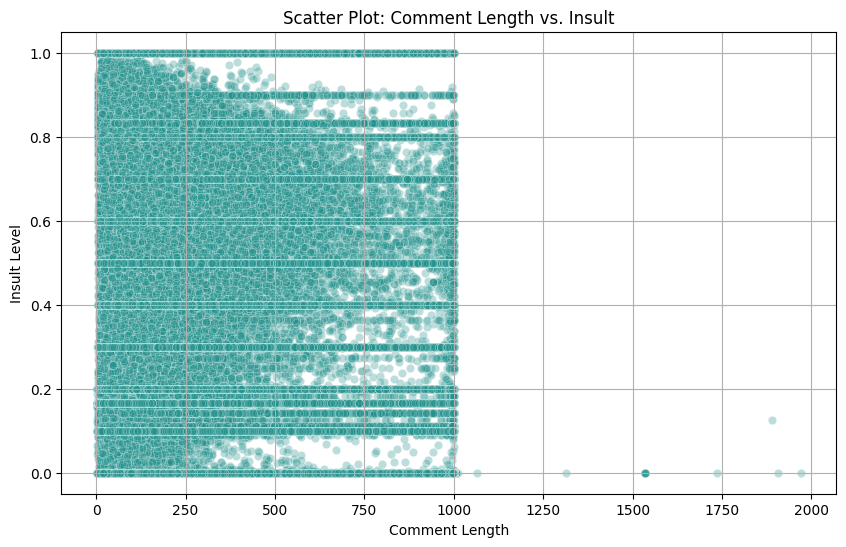

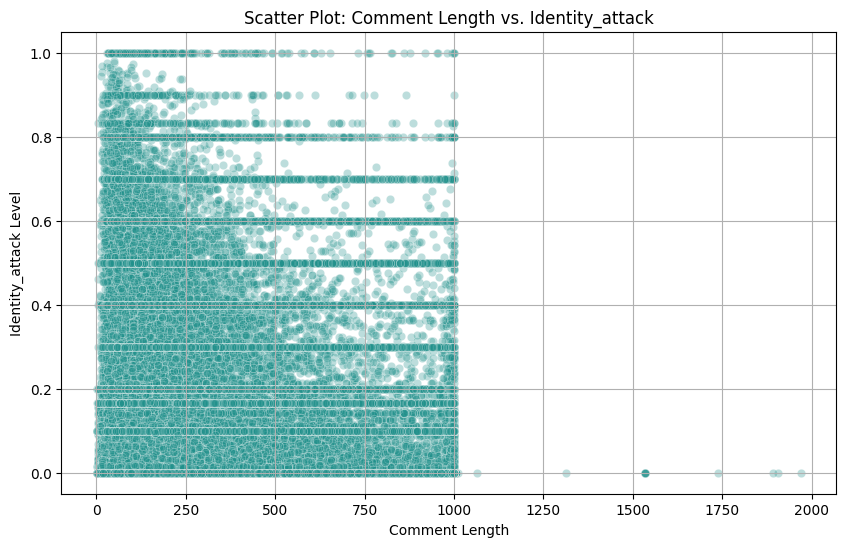

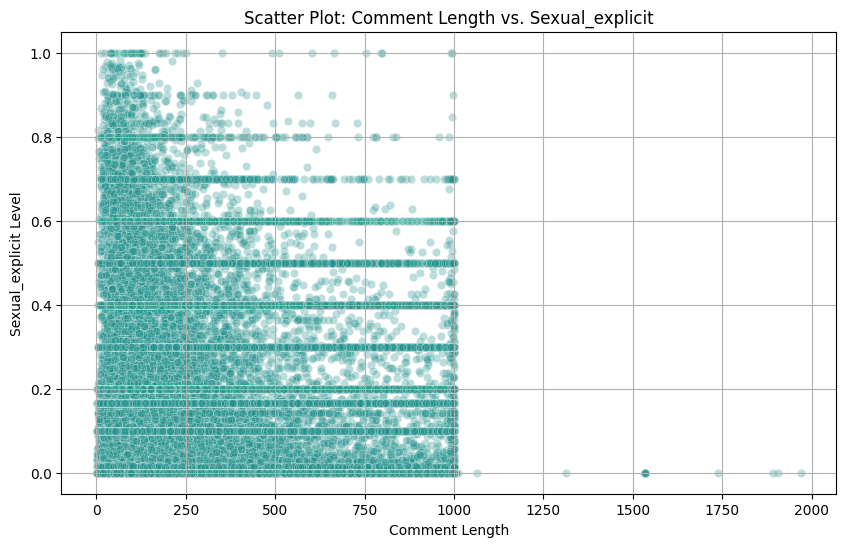

In [20]:
for label in toxicity_labels:
    plot_toxicity_vs_comment_length(df2, label=label, dataset='civil_comments')

In [21]:
# Define functions for dataset 3

def plot_sentiment_distribution_sst2(df):
    """
    Plots the distribution of sentiment labels in the SST-2 dataset.
    
    Input:
    - df (pd.DataFrame): Dataset containing a 'label' column with sentiment values (0 for negative, 1 for positive).
    
    Output:
    - Displays a bar plot showing the frequency of positive and negative sentiments.
    """
    sentiment_counts = df['label'].value_counts()
    #plot
    plt.figure(figsize=(7, 4))
    sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='viridis')
    plt.xticks([0, 1], ['Negative', 'Positive'])
    plt.title('Sentiment Distribution')
    plt.xlabel('Sentiment')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

def plot_sentiment_pie_chart_sst2(df):
    """
    Plots a pie chart showing the percentage of positive and negative sentiments in the SST-2 dataset.
    
    Input:
    - df (pd.DataFrame): Dataset containing a 'label' column with sentiment values (0 for negative, 1 for positive).
    
    Output:
    - Displays a pie chart of the sentiment distribution.
    """
    label_counts = df['label'].value_counts()
    # map the labels positive and negative
    labels = ['Negative', 'Positive']
    sizes = label_counts.values

    # plot
    plt.figure(figsize=(7, 4))
    explode = (0.1, 0) 
    plt.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', startangle=90, colors=['#3b528b', '#5ec962'])
    plt.title('Percentage of Positive and Negative Sentences')
    plt.axis('equal') 
    plt.show()

    
def plot_wordclouds_sst2(df):
    """
    Generates and displays word clouds for positive and negative sentences in the SST-2 dataset.
    
    Input:
    - df (pd.DataFrame): Dataset containing a 'label' column (0 for negative, 1 for positive) 
      and a 'sentence' column with text data.
    
    Output:
    - Displays two word clouds, one for positive sentences and one for negative sentences.
    """
    positive_sentence = ' '.join(df[df['label'] == 1]['sentence'])
    negative_sentence= ' '.join(df[df['label'] == 0]['sentence'])
    negative_wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='Reds').generate(negative_sentence)
    positive_wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='Greens').generate(positive_sentence)    

    # plot 
    plt.figure(figsize=(14, 7))
    plt.subplot(1, 2, 1)
    plt.imshow(positive_wordcloud, interpolation='bilinear')
    plt.title('Word Cloud: Positive Sentences', fontsize=16)
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(negative_wordcloud, interpolation='bilinear')
    plt.title('Word Cloud: Negative Sentences', fontsize=16)
    plt.axis('off')
    plt.tight_layout()
    plt.show()


        
def analyze_sentence_length_sst2(df):
    """
    Analyzes and visualizes sentence lengths in the SST-2 dataset.
    
    Input:
    - df (pd.DataFrame): Dataset containing a 'sentence' column with text data 
      and a 'label' column (0 for negative, 1 for positive).
    
    Output:
    - Displays basic statistics for sentence lengths, a histogram for their distribution, 
      and a box plot comparing lengths between positive and negative sentiments.
    """
    # calculate sentence lengths
    df['sentence_length'] = df['sentence'].apply(len)
    # basic statistics
    print("Basic Statistics for Sentence Lengths:")
    print(df['sentence_length'].describe())
    print("\n")
    
    # plot the distribution of sentence lengths
    plt.figure(figsize=(10, 4))
    sns.histplot(df['sentence_length'], bins=20, kde=True, color='#21918c')
    plt.title('Distribution of Sentence Lengths')
    plt.xlabel('Sentence Length')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

    # compare lengths for positive and negative sentiments
    plt.figure(figsize=(7, 4))
    sns.boxplot(data=df, x='label', y='sentence_length', palette='viridis')
    plt.xticks([0, 1], ['Negative', 'Positive'])
    plt.title('Sentence Length Comparison: Negative vs. Positive')
    plt.xlabel('Sentiment')
    plt.ylabel('Sentence Length')
    plt.grid(True)
    plt.show()

def plot_avg_sentence_length_by_sentiment_sst2(df):
    """
    Plots the average sentence length for negative and positive sentiments in the SST-2 dataset.
    
    Input:
    - df (pd.DataFrame): Dataset containing a 'sentence' column with text data 
      and a 'label' column (0 for negative, 1 for positive).
    
    Output:
    - Displays a bar plot comparing the average sentence length for each sentiment.
    """
    # calculate sentence length 
    if 'sentence_length' not in df.columns:
        df['sentence_length'] = df['sentence'].apply(len)
    # average sentence length by sentiment
    avg_length = df.groupby('label')['sentence_length'].mean().reset_index()
    
    # plot
    plt.figure(figsize=(7, 4))
    sns.barplot(data=avg_length, x='label', y='sentence_length', palette='viridis')
    plt.xticks([0, 1], ['Negative', 'Positive'])
    plt.title('Average Sentence Length: Negative vs. Positive')
    plt.xlabel('Sentiment')
    plt.ylabel('Average Sentence Length')
    plt.grid(True)
    plt.show()

def plot_word_frequency_sst2(df, label, top_n=10):
    """
    Plots the most common words in positive or negative sentences from the SST-2 dataset.
    
    Input:
    - df (pd.DataFrame): Dataset containing a 'sentence' column with text data 
      and a 'label' column (0 for negative, 1 for positive).
    - label (int): Sentiment to filter sentences by (0 for negative, 1 for positive).
    - top_n (int): Number of most frequent words to display (default is 10).
    
    Output:
    - Displays a bar plot showing the frequency of the top words for the selected sentiment.
    """
    #define stop words
    stop_words = set(stopwords.words('english'))
    # filter sentences by sentiment
    text = ' '.join(df[df['label'] == label]['sentence'])
    
    tokens = clean_and_tokenize(text, stop_words)
    # select the most common words
    word_counts = Counter(tokens)
    common_words = word_counts.most_common(top_n)

    # plot
    words, counts = zip(*common_words)
    plt.figure(figsize=(7, 4))
    sns.barplot(x=list(counts), y=list(words), palette='viridis')
    plt.title(f'Most Common Words in {"Positive" if label == 1 else "Negative"} Sentences')
    plt.xlabel('Frequency')
    plt.ylabel('Words')
    plt.grid(True)
    plt.show()



In [22]:
# Dataset 3: stanfordnlp/sst2

df3 = load_full_dataset("../data/finetuning_datasets/sst2")

# determine the number of hidden labels (-1)
hidden_label_count = (df3['label'] == -1).sum()
print(f"Number of hidden labels in the dataset: {hidden_label_count}")
# filter out hidden labels
df3 = df3[df3['label'] != -1]

display_dataset_info(df3)

Number of hidden labels in the dataset: 1821
Dataset info: 
<class 'pandas.core.frame.DataFrame'>
Index: 68221 entries, 0 to 70041
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   idx       68221 non-null  int32 
 1   sentence  68221 non-null  object
 2   label     68221 non-null  int64 
dtypes: int32(1), int64(1), object(1)
memory usage: 1.8+ MB
----------------------------------------------------------------

 First 5 rows of the dataset: 
     idx                                           sentence  label
0  50989  mazel tov to a film about a family 's joyous l...      1
1  43922                                 a subzero version       0
2  49814                 by the sheer beauty of his images       1
3  29277  ( f ) rom the performances and the cinematogra...      1
4  35821                                          monotony       0
----------------------------------------------------------------


In [24]:
count_nulls(df3)

idx         0
sentence    0
label       0
dtype: int64

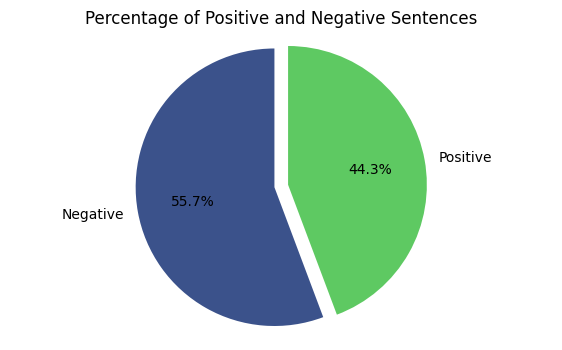

In [25]:
plot_sentiment_pie_chart_sst2(df3)

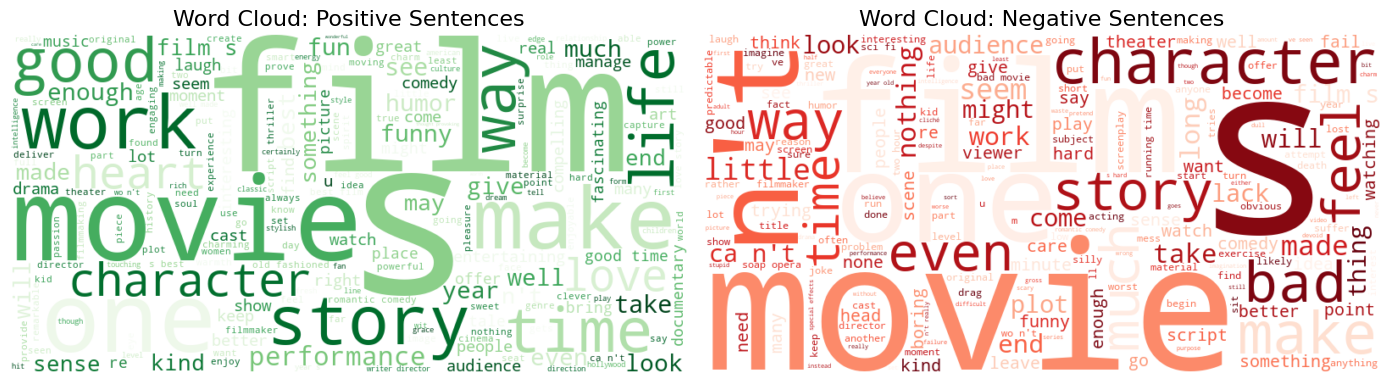

In [26]:
plot_wordclouds_sst2(df3)

Basic Statistics for Sentence Lengths:
count    68221.000000
mean        54.174550
std         43.866399
min          2.000000
25%         21.000000
50%         39.000000
75%         75.000000
max        268.000000
Name: sentence_length, dtype: float64




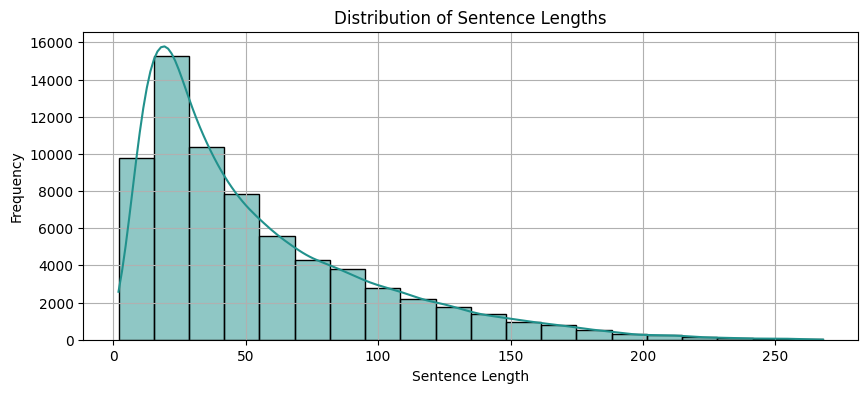

/var/folders/1m/1wt5d5154bg4twk9y67kbx3w0000gn/T/ipykernel_98968/4259226580.py:109: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='label', y='sentence_length', palette='viridis')


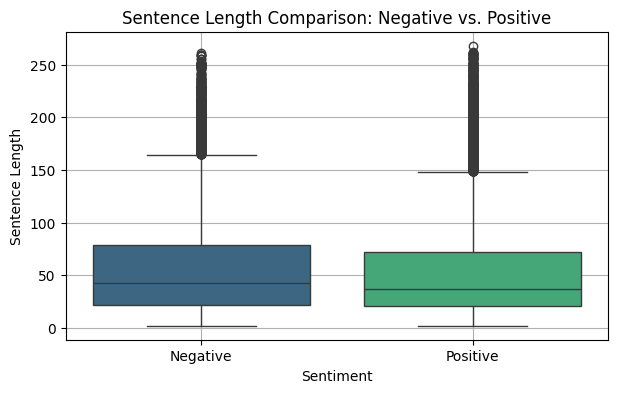

In [27]:
analyze_sentence_length_sst2(df3)

/var/folders/1m/1wt5d5154bg4twk9y67kbx3w0000gn/T/ipykernel_98968/4259226580.py:136: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=avg_length, x='label', y='sentence_length', palette='viridis')


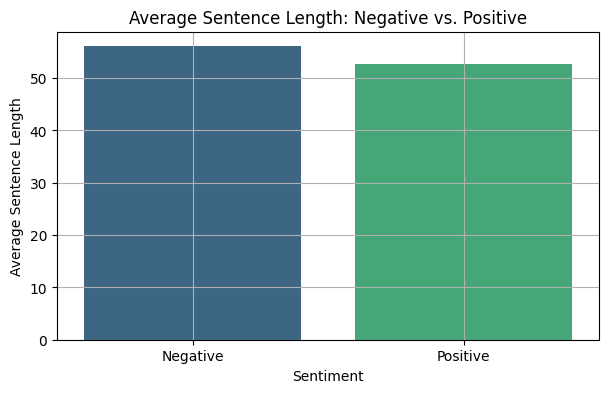

In [28]:
plot_avg_sentence_length_by_sentiment_sst2(df3)

/var/folders/1m/1wt5d5154bg4twk9y67kbx3w0000gn/T/ipykernel_98968/4259226580.py:170: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette='viridis')


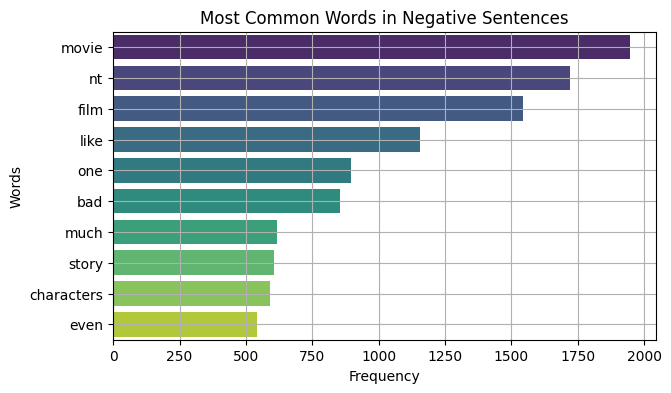

/var/folders/1m/1wt5d5154bg4twk9y67kbx3w0000gn/T/ipykernel_98968/4259226580.py:170: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette='viridis')


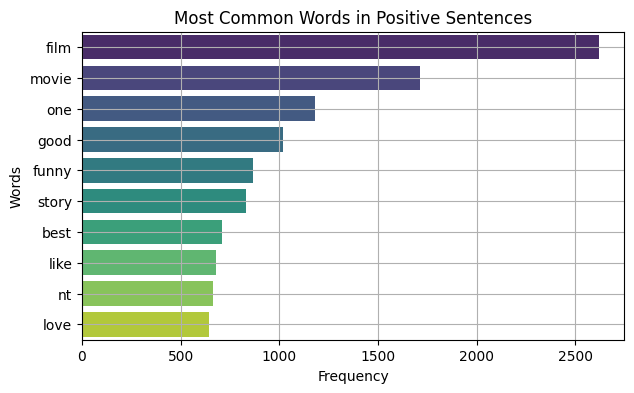

In [29]:
plot_word_frequency_sst2(df3, label=0, top_n=10)  # negative 
plot_word_frequency_sst2(df3, label=1, top_n=10)  # positive 